# (6m)Amplitudes

author: steeve.laquitaine@epfl.ch  
last modified:  22.07.2024  
status: up-to-date

## (7s)Setup

In [11]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import multiprocessing
import torch
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
import seaborn as sns
import pandas as pd
import matplotlib

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.validation import amplitude as amp

SF_V = 20000
SF_S = 20000

# denser probe (horvath)  ------
# vivo (probe 1)
cfg_hv1, _ = get_config("vivo_horvath", "probe_1").values()
PREP_PATH_hv1 = cfg_hv1["preprocessing"]["output"]["trace_file_path"]
# probe 2
cfg_hv2, _ = get_config("vivo_horvath", "probe_2").values()
PREP_PATH_hv2 = cfg_hv2["preprocessing"]["output"]["trace_file_path"]
# probe 3
cfg_hv3, _ = get_config("vivo_horvath", "probe_3").values()
PREP_PATH_hv3 = cfg_hv3["preprocessing"]["output"]["trace_file_path"]

# biophy. model
# (probe 1)
cfg_hs1, _ = get_config("silico_horvath", "concatenated/probe_1").values()
PREP_PATH_hs1 = cfg_hs1["preprocessing"]["output"]["trace_file_path"]
# probe 2
cfg_hs2, _ = get_config("silico_horvath", "concatenated/probe_2").values()
PREP_PATH_hs2 = cfg_hs2["preprocessing"]["output"]["trace_file_path"]
# probe 3
cfg_hs3, _ = get_config("silico_horvath", "concatenated/probe_3").values()
PREP_PATH_hs3 = cfg_hs3["preprocessing"]["output"]["trace_file_path"]

# Figure settings
COLOR_HV = [0.3, 0.3, 0.3]
COLOR_HS = np.array([26, 152, 80]) / 255 # green

cl = dict()
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green

# axes
FIG_SIZE = (1.7, 1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # minimum in literature
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame
savefig_cfg = {"transparent":True, "dpi": 300}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-07-23 15:02:54,335 - root - utils.py - get_config - INFO - Reading experiment config.
2024-07-23 15:02:54,350 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-07-23 15:02:54,351 - root - utils.py - get_config - INFO - Reading experiment config.
2024-07-23 15:02:54,360 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-07-23 15:02:54,360 - root - utils.py - get_config - INFO - Reading experiment config.
2024-07-23 15:02:54,370 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-07-23 15:02:54,370 - root - utils.py - get_config - INFO - Reading experiment config.
2024-07-23 15:02:54,390 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-07-23 15:02:54,390 - root - utils.py - get_config - INFO - Reading experiment config.
2024-07-23 15:02:54,405 - root - utils.py - get_config - INFO - R

## Specs

In [2]:
# cpus, gpu and current memory usage
print("available cpus:", multiprocessing.cpu_count())
print("available gpus:", torch.cuda.is_available())
%system free -m

available cpus: 80
available gpus: False


['              total        used        free      shared  buff/cache   available',
 'Mem:         385268       20757      109992          76      254517      363418',
 'Swap:             0           0           0']

## (1s)Load datasets

* first 10 minutes

In [2]:
# 1 - Load silico and vivo traces, select 10 min
# horvath
# probe 1, 2, 3
RecHS1 = si.load_extractor(PREP_PATH_hs1)
RecHV1 = si.load_extractor(PREP_PATH_hv1)
RecHS2 = si.load_extractor(PREP_PATH_hs2)
RecHV2 = si.load_extractor(PREP_PATH_hv2)
RecHS3 = si.load_extractor(PREP_PATH_hs3)
RecHV3 = si.load_extractor(PREP_PATH_hv3)

# 3. get traces
# horvath
traces_hs1 = RecHS1.get_traces()
traces_hv1 = RecHV1.get_traces()
traces_hs2 = RecHS2.get_traces()
traces_hv2 = RecHV2.get_traces()
traces_hs3 = RecHS3.get_traces()
traces_hv3 = RecHV3.get_traces()

# 4 - get good sites (in cortex)
# neuropixels
lyrs = ["L1", "L2/3", "L4", "L5", "L6"]

# horvath
# silico
# probe 1 (select L1, L2/3)
site_ly_hs1 = RecHS1.get_property("layers")
site_ly_hs1 = np.array(["L2/3" if x == "L2" or x == "L3" else x for x in site_ly_hs1])
site_ly_hs1 = np.array(["L2/3" if x == "L2_3" else x for x in site_ly_hs1])
sites_hs1 = np.where(np.isin(site_ly_hs1, ["L1", "L2/3"]))[0]
# probe 2 (select L4 and L5)
site_ly_hs2 = RecHS2.get_property("layers")
sites_hs2 = np.where(np.isin(site_ly_hs2, ["L4", "L5"]))[0]
# probe 3 (select L6)
site_ly_hs3 = RecHS3.get_property("layers")
site_ly_hs3 = np.array(["L2/3" if x == "L2" or x == "L3" else x for x in site_ly_hs3])
site_ly_hs3 = np.array(["L2/3" if x == "L2_3" else x for x in site_ly_hs3])
sites_hs3 = np.where(np.isin(site_ly_hs3, ["L6"]))[0]

# vivo
# probe 1 (select L1, L2/3)
site_ly_hv1 = RecHV1.get_property("layers")
site_ly_hv1 = np.array(["L2/3" if x == "L2_3" else x for x in site_ly_hv1])
sites_hv1 = np.where(np.isin(site_ly_hv1, ["L1", "L2/3"]))[0]
# probe 2 (select L4, L5)
site_ly_hv2 = RecHV2.get_property("layers")
sites_hv2 = np.where(np.isin(site_ly_hv2, ["L4", "L5"]))[0]
# probe 3 (select L6)
site_ly_hv3 = RecHV3.get_property("layers")
sites_hv3 = np.where(np.isin(site_ly_hv3, ["L6"]))[0]

## (2.5m)Report amplitudes

In [5]:
# depth 1
print("\nDepth 1:\n")
print("Horvath depth 1:", np.max(np.absolute(traces_hv1[:, sites_hv1])))
print("Horvath depth 1 (all sites):", np.max(np.absolute(traces_hv1)))
print("Biophy. dense probe depth 1:", np.max(np.absolute(traces_hs1[:, sites_hs1])))
print(
    "Biophy. dense probe depth 1 (all sites):",
    np.max(np.absolute(traces_hs1)),
)

# depth 2
print("\nDepth 2:\n")
print("Horvath depth 2:", np.max(np.absolute(traces_hv2[:, sites_hv2])))
print("Horvath depth 2 (all sites):", np.max(np.absolute(traces_hv2)))
print("Biophy. dense probe depth 2:", np.max(np.absolute(traces_hs2[:, sites_hs2])))
print(
    "Biophy. dense probe depth 2 (all sites):",
    np.max(np.absolute(traces_hs2)),
)

# depth 3
print("\nDepth 3:\n")
print("Horvath depth 3:", np.max(np.absolute(traces_hv3[:, sites_hv3])))
print("Horvath depth 3 (all sites):", np.max(np.absolute(traces_hv3)))
print("Biophy. dense probe depth 3:", np.max(np.absolute(traces_hs3[:, sites_hs3])))
print(
    "Biophy. dense probe depth 3 (all sites):",
    np.max(np.absolute(traces_hs3)),
)


Depth 1:

Horvath depth 1: 4129
Horvath depth 1 (all sites): 4129
Biophy. dense probe depth 1: 4157.35
Biophy. dense probe depth 1 (all sites): 4157.35

Depth 2:

Horvath depth 2: 3744
Horvath depth 2 (all sites): 3744
Biophy. dense probe depth 2: 3687.8525
Biophy. dense probe depth 2 (all sites): 3687.8525

Depth 3:

Horvath depth 3: 3390
Horvath depth 3 (all sites): 4064
Biophy. dense probe depth 3: 3277.8064
Biophy. dense probe depth 3 (all sites): 3850.3599


## (10m)Compute

In [3]:
# compute max per site
# vivo
maxs_hv1 = np.absolute(traces_hv1[:, sites_hv1]).max(axis=0)
maxs_hv2 = np.absolute(traces_hv2[:, sites_hv2]).max(axis=0)
maxs_hv3 = np.absolute(traces_hv3[:, sites_hv3]).max(axis=0)

# biophy
maxs_hs1 = np.absolute(traces_hs1[:, sites_hs1]).max(axis=0)
maxs_hs2 = np.absolute(traces_hs2[:, sites_hs2]).max(axis=0)
maxs_hs3 = np.absolute(traces_hs3[:, sites_hs3]).max(axis=0)

# Format plot data

# vivo
# L1, 2/3
df1 = pd.DataFrame()
df1["amplitude"] = maxs_hv1[
    (site_ly_hv1[sites_hv1] == "L1") | (site_ly_hv1[sites_hv1] == "L2/3")
]
df1["layer"] = site_ly_hv1[sites_hv1][
    (site_ly_hv1[sites_hv1] == "L1") | (site_ly_hv1[sites_hv1] == "L2/3")
]
df1["experiment"] = "Dense (Horvath)"
df1 = df1.sort_values(by="layer")

# L4, L5
df2 = pd.DataFrame()
df2["amplitude"] = maxs_hv2[
    (site_ly_hv2[sites_hv2] == "L4") | (site_ly_hv2[sites_hv2] == "L5")
]
df2["layer"] = site_ly_hv2[sites_hv2][
    (site_ly_hv2[sites_hv2] == "L4") | (site_ly_hv2[sites_hv2] == "L5")
]
df2["experiment"] = "Dense (Horvath)"
df2 = df2.sort_values(by="layer")

# L6
df3 = pd.DataFrame()
df3["amplitude"] = maxs_hv3[
    (site_ly_hv3[sites_hv3] == "L6") | (site_ly_hv3[sites_hv3] == "L6")
]
df3["layer"] = site_ly_hv3[sites_hv3][
    (site_ly_hv3[sites_hv3] == "L6") | (site_ly_hv3[sites_hv3] == "L6")
]
df3["experiment"] = "Dense (Horvath)"
df3 = df3.sort_values(by="layer")

# Biophy

# L1, 2/3
df4 = pd.DataFrame()
df4["amplitude"] = maxs_hs1[
    (site_ly_hs1[sites_hs1] == "L1") | (site_ly_hs1[sites_hs1] == "L2/3")
]
df4["layer"] = site_ly_hs1[sites_hs1][
    (site_ly_hs1[sites_hs1] == "L1") | (site_ly_hs1[sites_hs1] == "L2/3")
]
df4["experiment"] = "Dense (Biophy. spontaneous)"
df4 = df4.sort_values(by="layer")

# L4, L5
df5 = pd.DataFrame()
df5["amplitude"] = maxs_hs2[
    (site_ly_hs2[sites_hs2] == "L4") | (site_ly_hs2[sites_hs2] == "L5")
]
df5["layer"] = site_ly_hs2[sites_hs2][
    (site_ly_hs2[sites_hs2] == "L4") | (site_ly_hs2[sites_hs2] == "L5")
]
df5["experiment"] = "Dense (Biophy. spontaneous)"
df5 = df5.sort_values(by="layer")

# L6
df6 = pd.DataFrame()
df6["amplitude"] = maxs_hs3[
    (site_ly_hs3[sites_hs3] == "L6") | (site_ly_hs3[sites_hs3] == "L6")
]
df6["layer"] = site_ly_hs3[sites_hs3][
    (site_ly_hs3[sites_hs3] == "L6") | (site_ly_hs3[sites_hs3] == "L6")
]
df6["experiment"] = "Dense (Biophy. spontaneous)"
df6 = df6.sort_values(by="layer")

plot_data = pd.concat([df1, df2, df3, df4, df5, df6])
plot_data = plot_data.sort_values(by=["experiment", "layer"])

# unit-test
assert df1["layer"].unique().tolist() == ["L1", "L2/3"], "wrong layers"
assert df2["layer"].unique().tolist() == ["L4", "L5"], "wrong layers"
assert df3["layer"].unique().tolist() == ["L6"], "wrong layers"
assert df4["layer"].unique().tolist() == ["L1", "L2/3"], "wrong layers"
assert df5["layer"].unique().tolist() == ["L4", "L5"], "wrong layers"
assert df6["layer"].unique().tolist() == ["L6"], "wrong layer"

## (2s)Plot

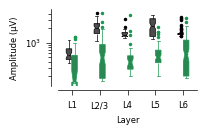

In [15]:
FIG_SIZE = (1.8, 1)

fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

ax = sns.boxplot(
    ax=ax,
    data=plot_data,
    x="layer",
    y="amplitude",
    hue="experiment",
    notch=True,
    hue_order=[
        "Dense (Horvath)",
        "Dense (Biophy. spontaneous)",
    ],
    palette=[COLOR_HV, COLOR_HS],
    width=0.4,
    linewidth=0.5,
    flierprops={
        "marker": ".",
        "markersize": 3,
    },
)

ax.set_yscale("log")

# axes
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# minor ticks
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=np.arange(0, 1.1, 0.1),
    numticks=10,
)
ax.tick_params(which="both")
ax.yaxis.set_minor_locator(locmin)

# labels
ax.set_ylabel("Amplitude (\u03bcV)")
ax.set_xlabel("Layer")

# customize the boxplot
p = 0
for box in ax.patches:
    if box.__class__.__name__ == "PathPatch":
        # a list item for each layer group
        if p in [0, 1, 2, 3, 4]:
            box.set_edgecolor(cl["COLOR_HV"])
            # Each box has 6 associated Line2D objects
            # (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour
            # as above
            # group 1 (HV)
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_HV"])  # box
                ax.lines[k].set_mfc(cl["COLOR_HV"])  # whisker
                ax.lines[k].set_mec(cl["COLOR_HV"])  # fliers
            p += 1
        elif p in [5, 6, 7, 8, 9]:
            # group 2 (HS)
            box.set_edgecolor(cl["COLOR_HS"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_HS"])
                ax.lines[k].set_mfc(cl["COLOR_HS"])
                ax.lines[k].set_mec(cl["COLOR_HS"])
            p += 1


## save figures
plt.savefig(
    "figures/0_validation/3_amplitude/fig2O/fig2O_horv.svg",
    bbox_inches="tight",
    **savefig_cfg
)

## Hyp. Test

### H0: Horvath median amplitude is the same across layers - No

Dunn's test
* Layer 2/3 is different from L1
* Layer 4 is same as 2/3 (p=0.8)
* Layer 5 is same as 4 (p=0.2)
* Layer 6 is same as 5 (p=0.7)

In [5]:
amp.get_kk(plot_data, "Dense (Horvath)")

# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
amp.get_posthoc_dunn_holm_sidak(plot_data, "Dense (Horvath)")

H=101.08914168299822, p=5.7670633413650496e-21
N_L1 = 36 sites
N_L23 = 60 sites
N_L4 = 20 sites
N_L5 = 88 sites
N_L6 = 68 sites


,1,2,3,4,5
1,1.000000e+00,2.194477e-11,0.000003,6.981552e-21,3.609922e-17
2,2.194477e-11,1.000000e+00,0.794768,6.143126e-02,2.687094e-01
3,3.202360e-06,7.947680e-01,1.000000,2.075577e-01,3.480898e-01
4,6.981552e-21,6.143126e-02,0.207558,1.000000e+00,7.326689e-01
5,3.609922e-17,2.687094e-01,0.348090,7.326689e-01,1.000000e+00


### H1: The model's median amplitude is the same across layers - No

Dunn's test
* Layer 2/3 is different from L1
* Layer 4 is same as 2/3 (p=0.9)
* Layer 5 is same as 4 (p=0.7)
* Layer 6 is same as 5 (p=0.9)

In [8]:
amp.get_kk(plot_data, "Dense (Biophy. spontaneous)")

# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
amp.get_posthoc_dunn_holm_sidak(plot_data, "Dense (Biophy. spontaneous)")

H=33.64928258792054, p=8.793705657226139e-07
N_L1 = 37 sites
N_L23 = 64 sites
N_L4 = 32 sites
N_L5 = 88 sites
N_L6 = 76 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,0.000353,0.013139,0.000002,7.436042e-07
L2/3,3.525313e-04,1.000000,0.888304,0.617283,5.969900e-01
L4,1.313899e-02,0.888304,1.000000,0.596990,5.328474e-01
L5,1.584216e-06,0.617283,0.596990,1.000000,8.883036e-01
L6,7.436042e-07,0.596990,0.532847,0.888304,1.000000e+00


### H1: The model amplitudes are same as Horvath's - no

In [9]:
print("\nlayer 1\n")
amp.get_mwu(plot_data, "Dense (Horvath)", "Dense (Biophy. spontaneous)", "L1")

print("\nlayer 2/3\n")
amp.get_mwu(plot_data, "Dense (Horvath)", "Dense (Biophy. spontaneous)", "L2/3")

print("\nlayer 4\n")
amp.get_mwu(plot_data, "Dense (Horvath)", "Dense (Biophy. spontaneous)", "L4")

print("\nlayer 5\n")
amp.get_mwu(plot_data, "Dense (Horvath)", "Dense (Biophy. spontaneous)", "L5")

print("\nlayer 6\n")
amp.get_mwu(plot_data, "Dense (Horvath)", "Dense (Biophy. spontaneous)", "L6")


layer 1

1 vs. 2, z=1033.0, p=3.012698404397808e-05, N_1=36, N_2=37

layer 2/3

1 vs. 2, z=3601.0, p=1.6027256655012695e-21, N_1=60, N_2=64

layer 4

1 vs. 2, z=594.0, p=9.580662447086689e-09, N_1=20, N_2=32

layer 5

1 vs. 2, z=7582.0, p=4.850676145614261e-40, N_1=88, N_2=88

layer 6

1 vs. 2, z=4608.0, p=8.939574568918484e-19, N_1=68, N_2=76
